## Titanic

This has become the "Hello World" of machine learning. Let's explore some features, select the important ones, and run some logistic regression, Naive Bayes and Random Forest models.

### Data

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')

import re
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split, GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [2]:
train = pd.read_csv("train.csv", dtype={'Age': np.float64}, )
test = pd.read_csv("test.csv", dtype={'Age': np.float64}, )

train.describe(include='all')

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Olsvigen, Mr. Thor Anderson",male,NaN,NaN,NaN,347082,NaN,C23 C25 C27,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


In [3]:
test.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


### Pclass

Pclass seems pretty useful. If you were in first class, you had a higher chance of survival.

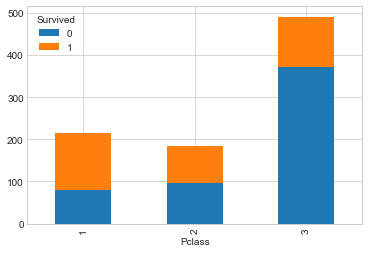

In [5]:
train.pivot_table('PassengerId', 'Pclass', 'Survived', 'count').plot(kind='bar', stacked=True)

### Names
Names could be useful - the titles denote social status and stuff like that.

In [6]:
train['Title'] = train['Name'].apply(lambda x: (re.search(' ([a-zA-Z]+)\.', x)).group(1))
test['Title'] = test['Name'].apply(lambda x: (re.search(' ([a-zA-Z]+)\.', x)).group(1))

titles = {'Capt':       'Officer',
          'Col':        'Officer',
          'Major':      'Officer',
          'Jonkheer':   'Royalty',
          'Don':        'Royalty',
          'Sir' :       'Royalty',
          'Dr':         'Officer',
          'Rev':        'Officer',
          'Countess':   'Royalty',
          'Dona':       'Royalty',
          'Mme':        'Mrs',
          'Mlle':       'Miss',
          'Ms':         'Mrs',
          'Mr' :        'Mr',
          'Mrs' :       'Mrs',
          'Miss' :      'Miss',
          'Master' :    'Master',
          'Lady' :      'Royalty'
                    } 

for k,v in titles.items():
    train.loc[train['Title'] == k, 'Title'] = v
    test.loc[test['Title'] == k, 'Title'] = v

#New frequencies.
train['Title'].value_counts()

Mr         517
Miss       184
Mrs        127
Master      40
Officer     18
Royalty      5
Name: Title, dtype: int64

### Age
Let's fill in some missing values.

In [7]:
print(train.groupby(['Sex', 'Pclass', 'Title', ])['Age'].median())

Sex     Pclass  Title  
female  1       Miss       30.0
                Mrs        40.0
                Officer    49.0
                Royalty    40.5
        2       Miss       24.0
                Mrs        31.5
        3       Miss       18.0
                Mrs        31.0
male    1       Master      4.0
                Mr         40.0
                Officer    51.0
                Royalty    40.0
        2       Master      1.0
                Mr         31.0
                Officer    46.5
        3       Master      4.0
                Mr         26.0
Name: Age, dtype: float64


In [8]:
train['Age'] = train.groupby(['Sex','Pclass','Title'])['Age'].apply(lambda x: x.fillna(x.median()))
test['Age'] = test.groupby(['Sex','Pclass','Title'])['Age'].apply(lambda x: x.fillna(x.median()))

##Another alternative, just impute median value:
#impute_value = train['Age'].median()
#train['Age'] = train['Age'].fillna(impute_value)
#test['Age'] = test['Age'].fillna(impute_value)
#test['Fare'] = test['Fare'].fillna(train['Fare'].median())


### Sex
Women and children first! Either male or female, though this category will have more options as the LGBTQ community's voice becomes louder.

In [9]:
train.groupby(['Pclass', 'Sex'])['Survived'].value_counts(normalize=True)

##Can also impute boolean variables:
#train['IsFemale'] = (train['Sex'] == 'female').astype(int)
#test['IsFemale'] = (test['Sex'] == 'female').astype(int)

Pclass  Sex     Survived
1       female  1           0.968085
                0           0.031915
        male    0           0.631148
                1           0.368852
2       female  1           0.921053
                0           0.078947
        male    0           0.842593
                1           0.157407
3       female  0           0.500000
                1           0.500000
        male    0           0.864553
                1           0.135447
Name: Survived, dtype: float64

### Family size
Larger families seemed to have a better chance of survival, presumably because some parents were allowed to accompany their children.

In [10]:
train['Family'] = train['Parch'] + train['SibSp']
test['Family'] = test['Parch'] + test['SibSp']
train.groupby(['Family'])['Survived'].value_counts(normalize=True)

Family  Survived
0       0           0.696462
        1           0.303538
1       1           0.552795
        0           0.447205
2       1           0.578431
        0           0.421569
3       1           0.724138
        0           0.275862
4       0           0.800000
        1           0.200000
5       0           0.863636
        1           0.136364
6       0           0.666667
        1           0.333333
7       0           1.000000
10      0           1.000000
Name: Survived, dtype: float64

In [11]:
def FamilySize(x):
    """
    A function for Family size transformation
    """
    if x == 1 or x == 2:
        return 'little'
    elif x == 3:
        return 'medium'
    elif x >= 5:
        return 'big'
    else:
        return 'single'

train['Family'] = train['Family'].apply(lambda x : FamilySize(x))
test['Family'] = test['Family'].apply(lambda x : FamilySize(x))

In [12]:
train.groupby(['Pclass', 'Family'])['Survived'].mean()

Pclass  Family
1       big       0.500000
        little    0.734043
        medium    0.714286
        single    0.540541
2       big       1.000000
        little    0.600000
        medium    0.769231
        single    0.352381
3       big       0.095238
        little    0.384615
        medium    0.666667
        single    0.205357
Name: Survived, dtype: float64

### Ticket prefix
This seems to have some effect as well, presumably because tickets with the same prefix tended to cluster together. 

In [13]:
def Ticket_Prefix(x):
    """
    Function for extracting prefixes. Tickets have length of 1-3.
    """
    l = x.split()
    if len(x.split()) == 3:
        return x.split()[0] + x.split()[1]
    elif len(x.split()) == 2:
        return x.split()[0]
    else:
        return 'None'

train['TicketPrefix'] = train['Ticket'].apply(lambda x: Ticket_Prefix(x))
test['TicketPrefix'] = test['Ticket'].apply(lambda x: Ticket_Prefix(x))

### Fare
This seems to have quite a large effect, passengers who paid more had better chances of survival. We need to impute the missing value in the test set too.

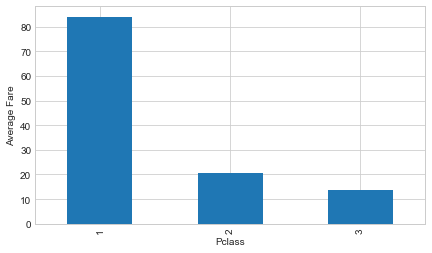

In [14]:
ax = plt.subplot()
ax.set_ylabel('Average Fare')
train.groupby('Pclass').mean()['Fare'].plot(kind='bar',figsize=(7, 4), ax=ax)
test['Fare'] = test.groupby(['Pclass'])['Fare'].apply(lambda x: x.fillna(x.median()))

### Cabin type
Turned out to be quite important as well. 

In [15]:
train.Cabin.fillna('Unknown',inplace=True)
test.Cabin.fillna('Unknown',inplace=True)

train['Cabin'] = train['Cabin'].map(lambda x: x[0])
test['Cabin'] = test['Cabin'].map(lambda x: x[0])

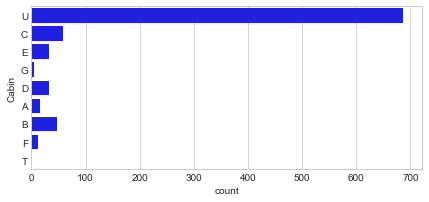

In [16]:
f, ax = plt.subplots(figsize=(7, 3))
sns.countplot(y='Cabin', data=train, color='b')

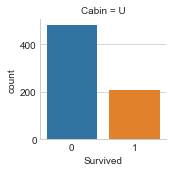

In [17]:
#Most with unknown cabin did not survive:
sns.factorplot('Survived', col='Cabin', col_wrap=4, data=train[train.Cabin == 'U'], kind='count', size=2.5, aspect=.8)

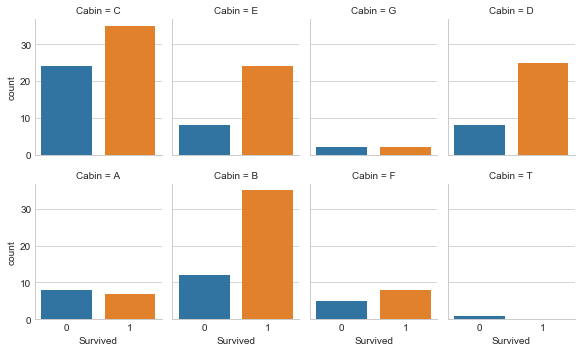

In [18]:
#For passengers with known Cabins survival rate varies.
sns.factorplot('Survived', col='Cabin', col_wrap=4, data=train[train.Cabin != 'U'], kind='count', size=2.5, aspect=.8)

In [19]:
train.groupby(['Cabin']).mean()[train.groupby(['Cabin']).mean().columns[1:2]]

,Survived
Cabin,
A,0.466667
B,0.744681
C,0.593220
D,0.757576
E,0.750000
F,0.615385
G,0.500000
T,0.000000
U,0.299854


### Embarked
Impute with most common value

In [20]:
MedEmbarked = train.groupby('Embarked').count()['PassengerId']
train.Embarked.fillna(MedEmbarked, inplace=True)

### Data after tidying

In [21]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Family,TicketPrefix
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,U,S,Mr,little,A/5
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,C,Mrs,little,PC
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,U,S,Miss,single,STON/O2.
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C,S,Mrs,little,None
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,U,S,Mr,single,None


In [22]:
#Drop unnecessary columns
to_drop = ['Ticket', 'Name', 'SibSp', 'Parch']
for i in to_drop:
    train.drop([i], axis=1, inplace=True)
    test.drop([i], axis=1, inplace=True)

In [23]:
#Pclass in fact is a categorical variable, though it's type isn't object.
for col in train.columns:
    if train[col].dtype == 'object' or col == 'Pclass':
        dummies = pd.get_dummies(train[col], drop_first=False)
        dummies = dummies.add_prefix('{}_'.format(col))
        train.drop(col, axis=1, inplace=True)
        train = train.join(dummies)
for col in test.columns:
    if test[col].dtype == 'object' or col == 'Pclass':
        dummies = pd.get_dummies(test[col], drop_first=False)
        dummies = dummies.add_prefix('{}_'.format(col))
        test.drop(col, axis=1, inplace=True)
        test = test.join(dummies)

In [24]:
X_train = train.drop('Survived',axis=1)
Y_train = train['Survived']
X_test  = test

### Feature selection
Use Random Forest to rank features

In [25]:
clf = RandomForestClassifier(n_estimators = 15,
                                criterion = 'gini',
                                max_features = 'sqrt',
                                max_depth = None,                                
                                min_samples_split =7,
                                min_weight_fraction_leaf = 0.0,
                                max_leaf_nodes = 18)
clf = clf.fit(X_train, Y_train)
indices = np.argsort(clf.feature_importances_)[::-1]

print('Feature ranking:')
for f in range(X_train.shape[1]):
    print('%d. feature %d %s (%f)' % (f + 1, indices[f], X_train.columns[indices[f]], clf.feature_importances_[indices[f]]))

Feature ranking:
1. feature 22 Title_Mr (0.188199)
2. feature 2 Fare (0.125579)
3. feature 7 Sex_male (0.113265)
4. feature 6 Sex_female (0.098753)
5. feature 1 Age (0.067419)
6. feature 23 Title_Mrs (0.062486)
7. feature 5 Pclass_3 (0.058513)
8. feature 16 Cabin_U (0.055301)
9. feature 21 Title_Miss (0.038005)
10. feature 0 PassengerId (0.024721)
11. feature 19 Embarked_S (0.017731)
12. feature 27 Family_little (0.016763)
13. feature 18 Embarked_Q (0.012913)
14. feature 17 Embarked_C (0.012685)
15. feature 4 Pclass_2 (0.012603)
16. feature 3 Pclass_1 (0.012340)
17. feature 26 Family_big (0.011242)
18. feature 28 Family_medium (0.009282)
19. feature 20 Title_Master (0.008266)
20. feature 29 Family_single (0.007793)
21. feature 9 Cabin_B (0.005359)
22. feature 12 Cabin_E (0.004930)
23. feature 48 TicketPrefix_PC (0.003501)
24. feature 10 Cabin_C (0.003485)
25. feature 44 TicketPrefix_F.C.C. (0.003056)
26. feature 13 Cabin_F (0.002761)
27. feature 24 Title_Officer (0.002753)
28. feature 

In [26]:
model = SelectFromModel(clf, prefit=True)
train_new = model.transform(X_train)
train_new.shape

#predictors = ['Pclass', 'IsFemale', 'Age', 'Fare']
#X_train = train[predictors].values
#X_test = test[predictors].values
#y_train = train['Survived'].values
#submission = pd.DataFrame(test.iloc[:, 0])

(891, 12)

In [27]:
best_features = X_train.columns[indices[0:train_new.shape[1]]]
X = X_train[best_features]
Xt = X_test[best_features]
best_features

Index(['Title_Mr', 'Fare', 'Sex_male', 'Sex_female', 'Age', 'Title_Mrs',
       'Pclass_3', 'Cabin_U', 'Title_Miss', 'PassengerId', 'Embarked_S',
       'Family_little'],
      dtype='object')

### Models

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, Y_train, test_size=0.33, random_state=44)

In [29]:
forest = RandomForestClassifier(max_depth = 50,                                
                                min_samples_split =7,
                                min_weight_fraction_leaf = 0.0,
                                max_leaf_nodes = 18)

parameter_grid = {'n_estimators' : [15, 100, 200],
                  'criterion' : ['gini', 'entropy'],
                  'max_features' : ['auto', 'sqrt', 'log2', None]
                 }

grid_search = GridSearchCV(forest, param_grid=parameter_grid, cv=StratifiedKFold(5))
grid_search.fit(X, Y_train)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

Best score: 0.8204264870931538
Best parameters: {'criterion': 'entropy', 'max_features': 'log2', 'n_estimators': 100}


In [30]:
forest = RandomForestClassifier(n_estimators = 200,
                                criterion = 'entropy',
                                max_features = None)
parameter_grid = {
                  'max_depth' : [None, 50],
                  'min_samples_split' : [7, 11],
                  'min_weight_fraction_leaf' : [0.0, 0.2],
                  'max_leaf_nodes' : [18, 20],
                 }

grid_search = GridSearchCV(forest, param_grid=parameter_grid, cv=StratifiedKFold(5))
grid_search.fit(X, Y_train)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

Best score: 0.8092031425364759
Best parameters: {'max_depth': None, 'max_leaf_nodes': 20, 'min_samples_split': 11, 'min_weight_fraction_leaf': 0.0}


In [31]:
#My optimal parameters
clf = RandomForestClassifier(n_estimators = 200,
                                criterion = 'entropy',
                                max_features = None,
                                max_depth = 50,                                
                                min_samples_split =7,
                                min_weight_fraction_leaf = 0.0,
                                max_leaf_nodes = 18)

clf.fit(X, Y_train)
Y_pred_RF = clf.predict(Xt)

clf.score(X_test,y_test)

0.86440677966101698

In [32]:
submission = pd.DataFrame({
        'PassengerId': test['PassengerId'],
    })

rf_submission = pd.DataFrame({
        'PassengerId': test['PassengerId'],
        'Survived': Y_pred_RF
    })

rf_submission.to_csv('rf_submission.csv', index=False)

### Naive Bayes classifier

In [44]:
gnb = GaussianNB()
nb_pred = gnb.fit(X_train, y_train).predict(Xt)
nb_submission = pd.DataFrame({
        'PassengerId': test['PassengerId'],
        'Survived': nb_pred
    })
nb_submission.to_csv('nb_submission.csv',index=False)

### Logistic Regression

In [45]:
from sklearn import model_selection

model = LogisticRegression()
model.fit(X_train, y_train)

kfold = model_selection.KFold(n_splits=10, random_state=7)
scoring = 'accuracy'
results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
print("Accuracy: " , results.mean()) 

y_predict = model.predict(Xt)

lr_submission = pd.DataFrame({
        'PassengerId': test['PassengerId'],
        'Survived': y_predict
    })
lr_submission.to_csv('lr_submission.csv',index=False)

Accuracy:  0.813700564972


### Final Score
Final accuracy of 79% for the RF model, about 70th percentile. I think I could do better, but just wanted to test some models.